In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

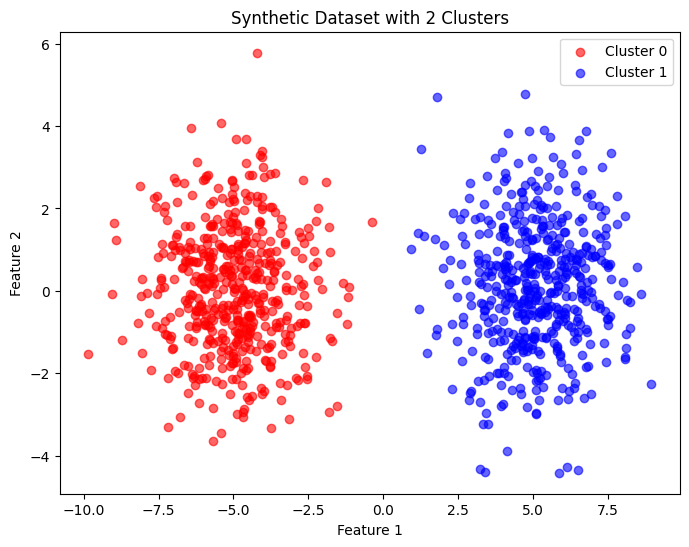

In [2]:
# Générer le dataset avec 2 clusters éloignés à gauche et à droite
n_samples = 1000  # Nombre d'échantillons
n_features = 2  # Nombre de caractéristiques (features)
centers = [[-5, 0], [5, 0]]  # Centres des clusters à gauche et à droite
cluster_std = 1.5  # Ecart-type des clusters

# Créer le dataset
X, y = make_blobs(n_samples=n_samples, centers=centers, n_features=n_features, 
                  cluster_std=cluster_std, random_state=42)

# Visualiser les clusters
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label='Cluster 0', alpha=0.6)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Cluster 1', alpha=0.6)
plt.title('Synthetic Dataset with 2 Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [3]:
X_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.long)

In [4]:
class MLPWithDropout(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate=0.4):
        super(MLPWithDropout, self).__init__()
        
        hidden_dims = [input_dim] + hidden_dims

        self.layers = nn.ModuleList()
        for i in range(1, len(hidden_dims)):
            self.layers.append(nn.Sequential(
            nn.Linear(hidden_dims[i-1], hidden_dims[i]),
            nn.ReLU(),
            nn.Dropout(dropout_rate)))

        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.output_layer(x)

# Initialiser le modèle
model = MLPWithDropout(input_dim=2, hidden_dims=[16], output_dim=2)

In [5]:
def get_entropy(prob: torch.Tensor):
    entropy = - prob * torch.log(prob) - (1 - prob) * torch.log(1 - prob)
    entropy[entropy != entropy] = 0  # nan to zero
    entropy = entropy.detach().cpu().numpy()

    return entropy

In [6]:
epochs = 100
learning_rate = 0.01

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Run training
for epoch in range(epochs):
    model.train()  # Passer le modèle en mode entraînement
    
    # Passer toutes les données d'un coup
    output = model(X_tensor)  # Prédiction du modèle

    # Conversion de la cible en one-hot
    target_one_hot = torch.zeros(X_tensor.size(0), 2)  # 2 est pour le nombre de classes
    target_one_hot[torch.arange(X_tensor.size(0)), y_tensor] = 1  # Conversion en one-hot
    
    # Calcul de la loss
    loss = nn.BCEWithLogitsLoss()(output, target_one_hot)
    
    # Calcul des gradients et mise à jour des poids
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Affichage de la loss pour chaque époque
    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.6f}")


Epoch 1/100 - Loss: 1.465453
Epoch 2/100 - Loss: 1.287862
Epoch 3/100 - Loss: 1.168146
Epoch 4/100 - Loss: 1.052644
Epoch 5/100 - Loss: 0.940311
Epoch 6/100 - Loss: 0.829301
Epoch 7/100 - Loss: 0.735416
Epoch 8/100 - Loss: 0.651430
Epoch 9/100 - Loss: 0.577043
Epoch 10/100 - Loss: 0.511121
Epoch 11/100 - Loss: 0.457939
Epoch 12/100 - Loss: 0.395427
Epoch 13/100 - Loss: 0.347739
Epoch 14/100 - Loss: 0.311020
Epoch 15/100 - Loss: 0.282095
Epoch 16/100 - Loss: 0.246795
Epoch 17/100 - Loss: 0.228398
Epoch 18/100 - Loss: 0.206556
Epoch 19/100 - Loss: 0.188750
Epoch 20/100 - Loss: 0.174095
Epoch 21/100 - Loss: 0.163903
Epoch 22/100 - Loss: 0.147898
Epoch 23/100 - Loss: 0.133011
Epoch 24/100 - Loss: 0.125975
Epoch 25/100 - Loss: 0.122961
Epoch 26/100 - Loss: 0.109962
Epoch 27/100 - Loss: 0.102118
Epoch 28/100 - Loss: 0.095918
Epoch 29/100 - Loss: 0.093240
Epoch 30/100 - Loss: 0.082836
Epoch 31/100 - Loss: 0.075974
Epoch 32/100 - Loss: 0.069445
Epoch 33/100 - Loss: 0.068289
Epoch 34/100 - Loss

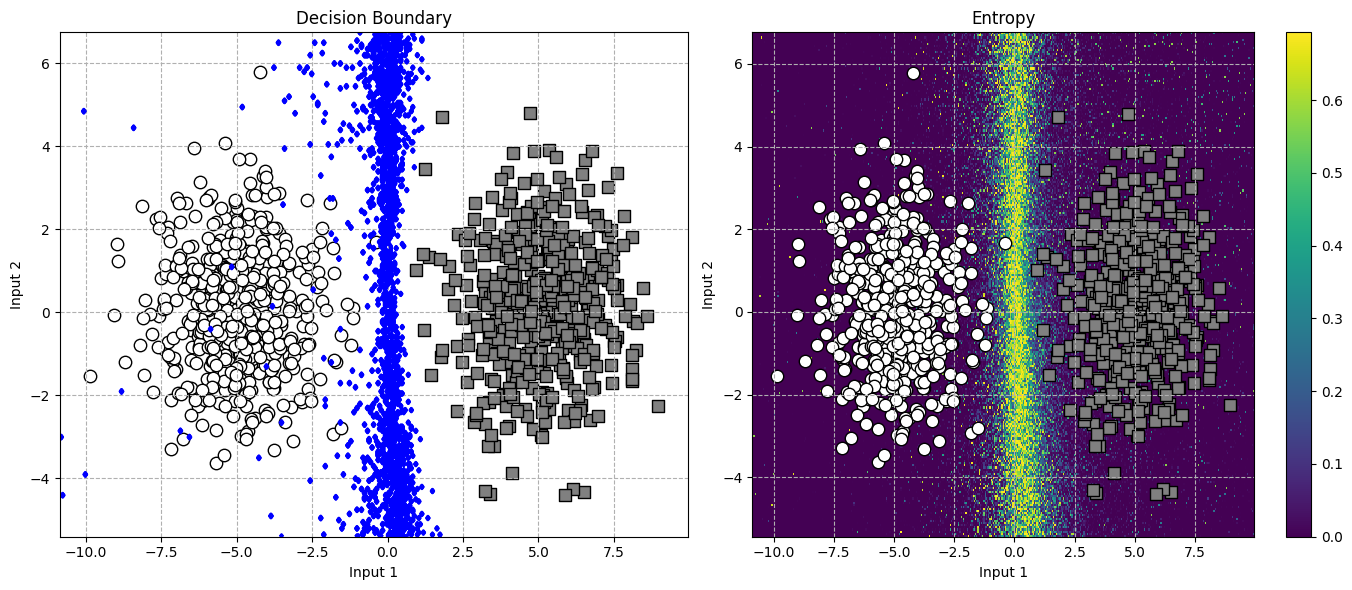

In [9]:
# Activer le dropout en mode évaluation
def enable_dropout(model):
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.train()

# Définir les limites de la grille en fonction de vos données
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = 0.05
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
data_meshgrid = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float)

# Initialisation des graphiques avant la boucle des epochs
fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(1, 2)

# Decision boundary
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_xlabel("Input 1")
ax1.set_ylabel("Input 2")
ax1.set_title("Decision Boundary")

# Entropy
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_xlabel("Input 1")
ax2.set_ylabel("Input 2")
ax2.set_title("Entropy")

# Après la fin de l'entraînement, effectuez le plot
model.eval()
enable_dropout(model)

# Décision et entropie pour la visualisation
output = model(data_meshgrid)  # Logits pour chaque point
prob = torch.softmax(output, dim=1)  # Probabilités pour chaque classe
prob_class_1 = prob[:, 1].view(xx.shape)  # Probabilité pour la classe 0
entropy = get_entropy(prob_class_1)  # Entropie basée sur les probabilités
pred = torch.argmax(prob, dim=1).view(xx.shape).detach().cpu().numpy()  # Classe prédite

# Affichage de la frontière de décision
ax1.contour(xx, yy, pred, colors=["blue"], linewidths=[2])

# Affichage de l'entropie
im = ax2.pcolormesh(xx, yy, entropy)  # Affichage de l'entropie
fig.colorbar(im, ax=ax2)

# Points de données (assurez-vous que y est une série ou un tenseur avec les bonnes dimensions)
for label, marker, color in zip([0, 1], ["o", "s"], ["white", "gray"]):
    _X = X[y == label]  # Filtrer les points par classe
    ax1.scatter(_X[:, 0], _X[:, 1], s=80, c=color, edgecolors="black", marker=marker)  # X est un DataFrame
    ax2.scatter(_X[:, 0], _X[:, 1], s=80, c=color, edgecolors="black", marker=marker)

ax1.grid(linestyle="--")
ax2.grid(linestyle="--")
plt.tight_layout()
plt.show()  # Affichage final du plot

tensor([[  7.0318, -14.3428],
        [ 17.2168, -17.9485],
        [ 12.7016, -12.6964],
        ...,
        [ -9.2397,  10.3963],
        [-11.9116,  11.9074],
        [-14.1223,  12.3810]], grad_fn=<AddmmBackward0>)


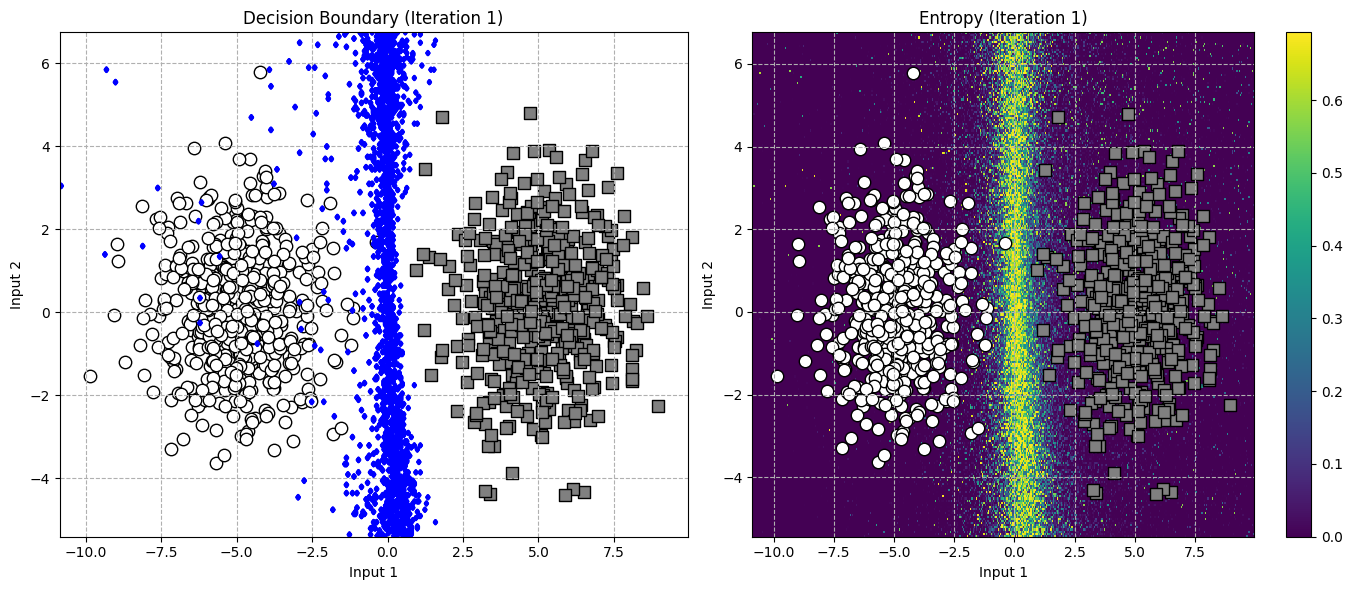

tensor([[ 18.1702, -30.2889],
        [  5.0529,  -7.7691],
        [ 19.1475, -26.0085],
        ...,
        [-11.4263,  10.6843],
        [-11.2940,  10.3937],
        [-14.5579,  13.5597]], grad_fn=<AddmmBackward0>)


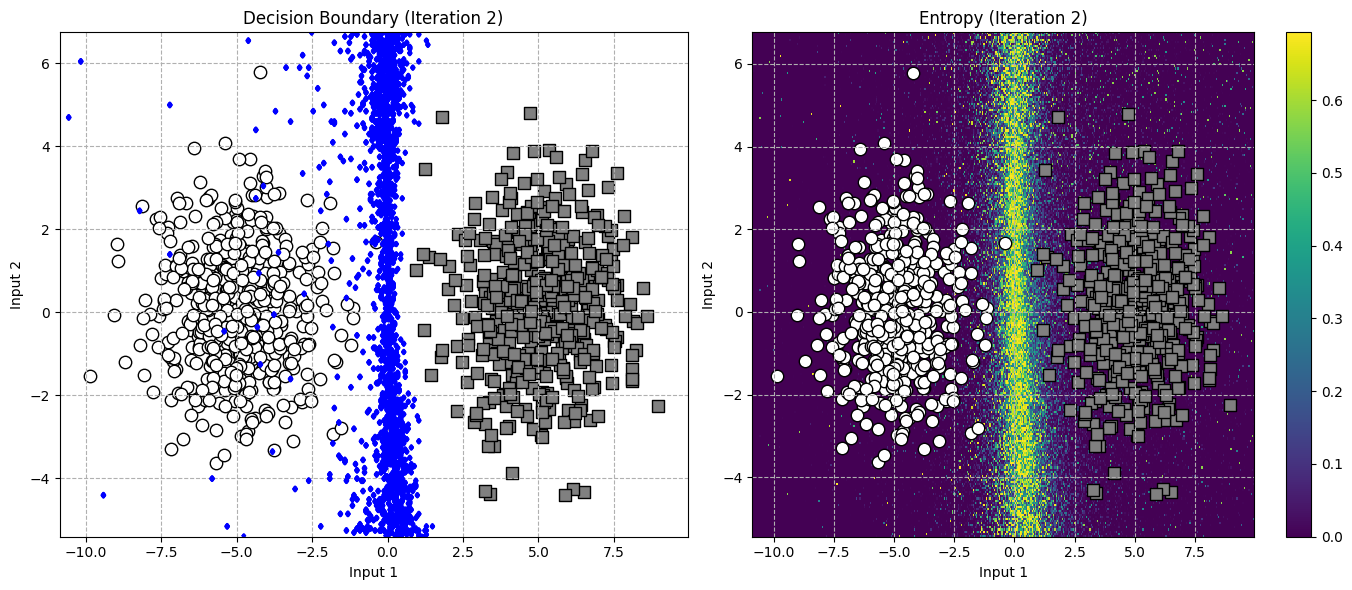

tensor([[ 24.6082, -33.0360],
        [ 18.4698, -28.5298],
        [ 20.0011, -23.1374],
        ...,
        [ -9.0589,  10.0614],
        [-14.0733,  12.4838],
        [ -9.3211,  10.4956]], grad_fn=<AddmmBackward0>)


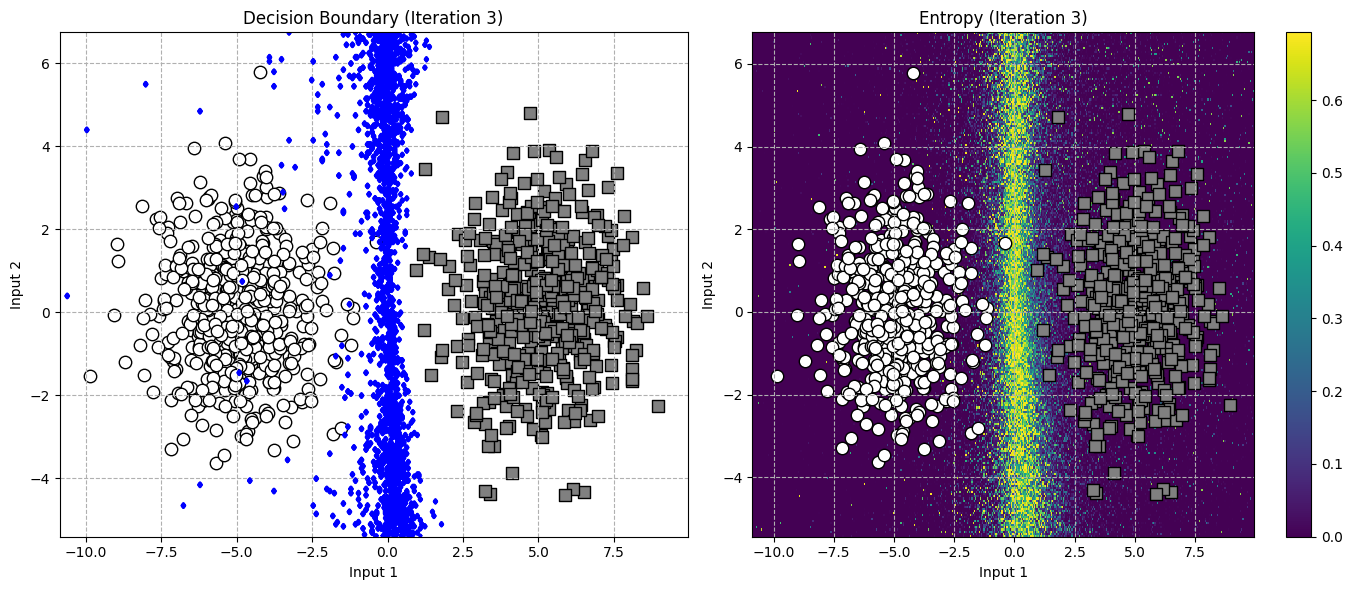

tensor([[ 24.6082, -33.0360],
        [ 20.7345, -33.0737],
        [ 16.5819, -24.8606],
        ...,
        [-13.8277,  12.0874],
        [ -6.1393,   6.1259],
        [-17.2034,  15.0300]], grad_fn=<AddmmBackward0>)


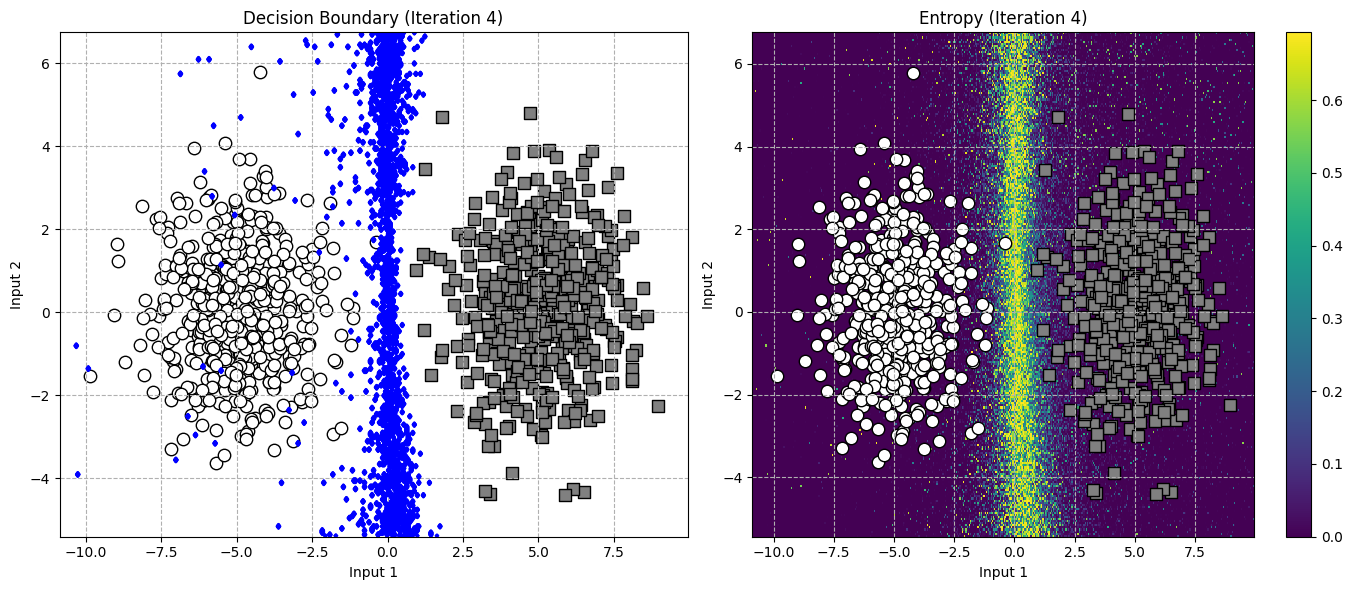

tensor([[ 28.0664, -34.9191],
        [ 23.9091, -29.5720],
        [ 14.5825, -22.0990],
        ...,
        [-19.5728,  17.8389],
        [-19.6610,  17.9232],
        [-12.0119,  10.5822]], grad_fn=<AddmmBackward0>)


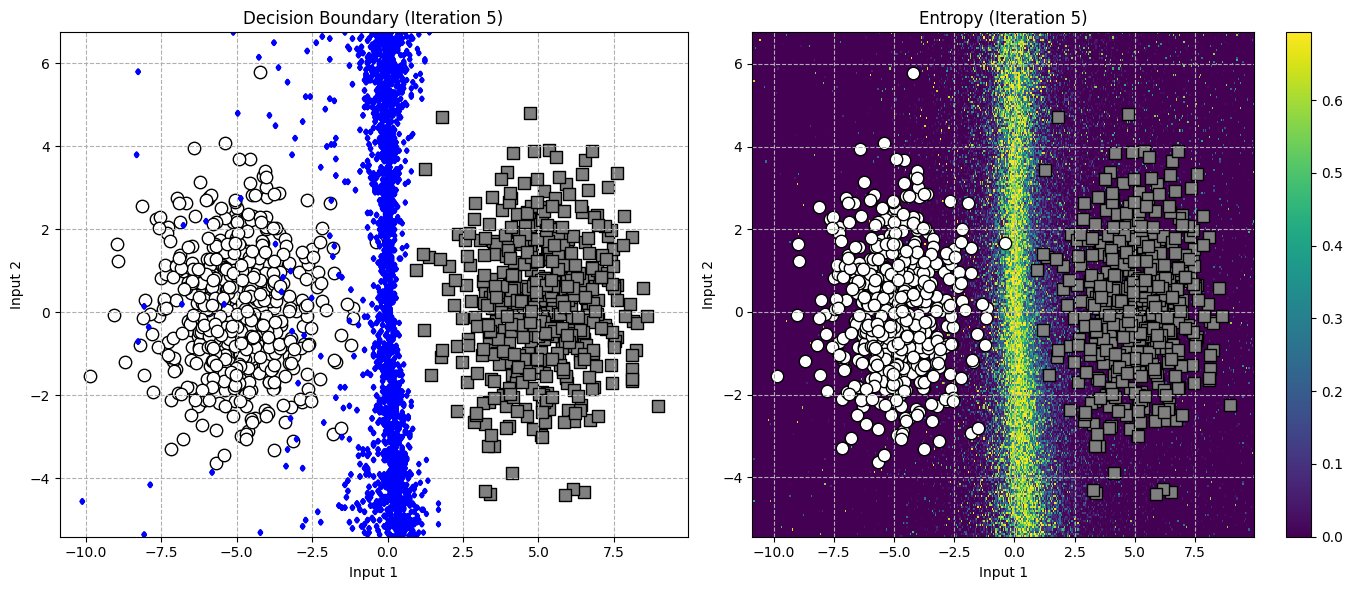

tensor([[ 25.0484, -38.5643],
        [ 23.3654, -30.4783],
        [ 22.1963, -24.4909],
        ...,
        [-19.3920,  17.5041],
        [-13.8887,  12.1418],
        [-19.7493,  18.0075]], grad_fn=<AddmmBackward0>)


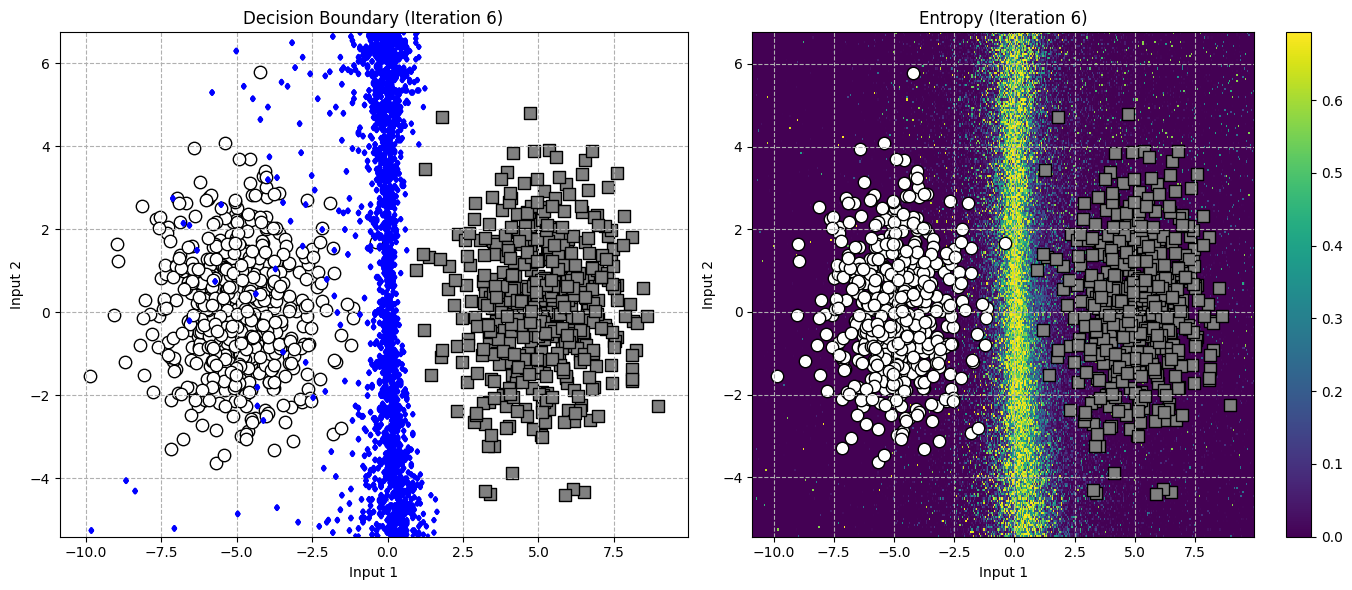

tensor([[ 21.5114, -23.3747],
        [ 20.3900, -26.0191],
        [ 27.6038, -36.3498],
        ...,
        [-19.3920,  17.5041],
        [-19.6610,  17.9232],
        [-11.9666,  11.9658]], grad_fn=<AddmmBackward0>)


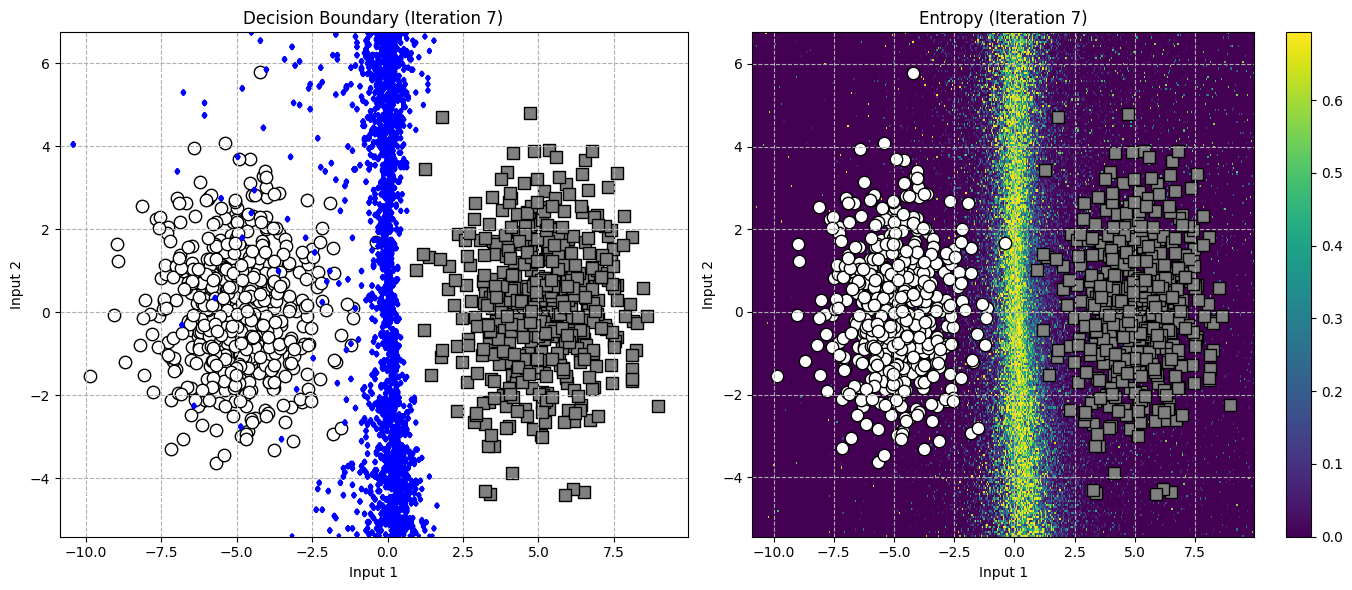

tensor([[ 31.7413, -41.1768],
        [  3.9920,  -7.0304],
        [ 26.4121, -33.2654],
        ...,
        [-10.8729,   7.9706],
        [ -8.6744,   9.0908],
        [-17.2034,  15.0300]], grad_fn=<AddmmBackward0>)


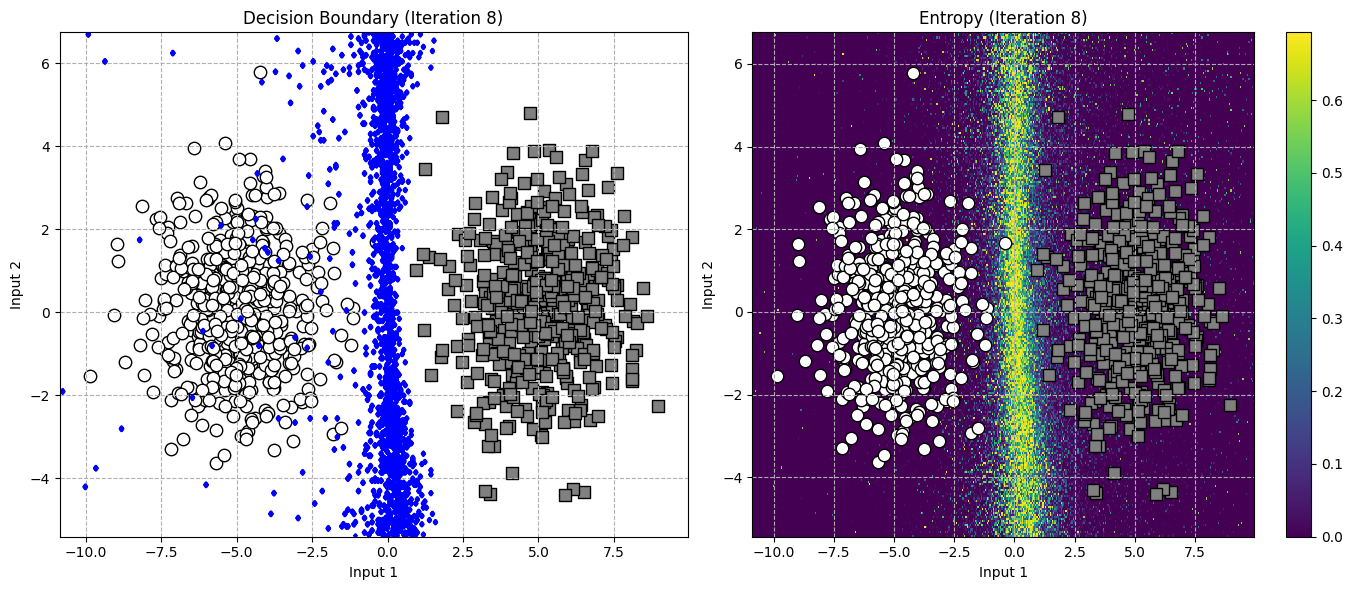

tensor([[ 20.8063, -27.6770],
        [ 13.5605, -11.7234],
        [ 16.0211, -21.4469],
        ...,
        [-14.0085,  12.4223],
        [-14.3100,  13.1549],
        [-14.5125,  14.9434]], grad_fn=<AddmmBackward0>)


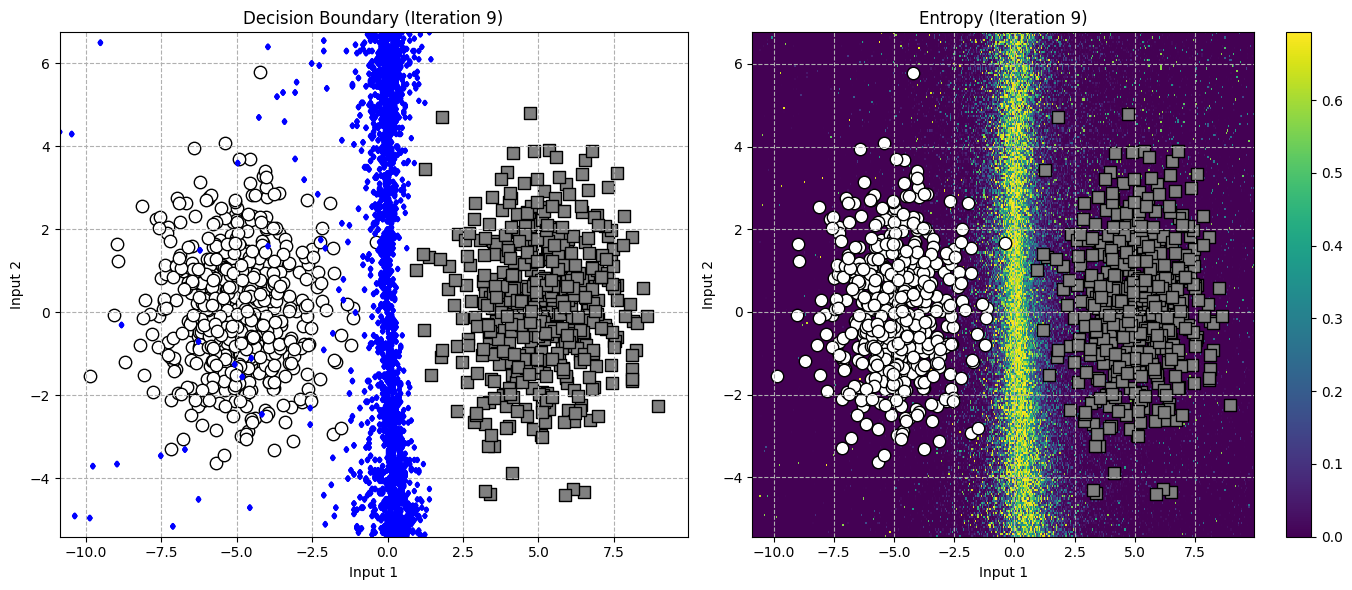

tensor([[ 25.0793, -31.1416],
        [ 30.7024, -40.9735],
        [ 23.1633, -31.1799],
        ...,
        [ -6.7153,   7.4440],
        [ -8.9069,   8.0574],
        [-14.1382,  12.5452]], grad_fn=<AddmmBackward0>)


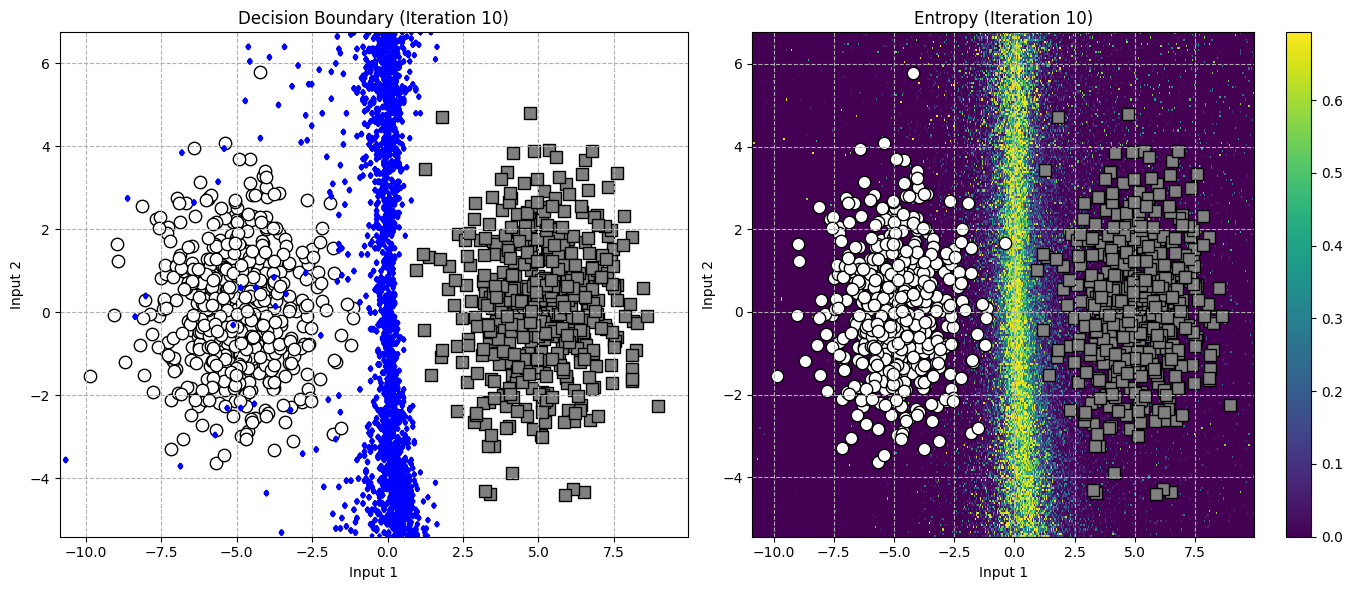

In [10]:
model.eval()
enable_dropout(model)

# Nombre de passes pour MC Dropout
num_passes = 10

# Effectuer plusieurs passes pour obtenir les prédictions
for i in range(num_passes):
    output = model.forward(data_meshgrid)  # Logits pour chaque point
    print(output)
    prob = torch.softmax(output, dim=1)  # Probabilités pour chaque classe
    prob_class_1 = prob[:, 1].view(xx.shape)  # Probabilité pour la classe 1
    pred = torch.argmax(prob, dim=1).view(xx.shape).detach().cpu().numpy()  # Classe prédite
    entropy = get_entropy(prob_class_1)  # Calcul de l'entropie

    # Créer un graphique pour l'itération actuelle
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Affichage de la frontière de décision
    ax1.contour(xx, yy, pred, colors=["blue"], linewidths=[2])
    ax1.set_xlabel("Input 1")
    ax1.set_ylabel("Input 2")
    ax1.set_title(f"Decision Boundary (Iteration {i + 1})")

    # Affichage de l'entropie
    im = ax2.pcolormesh(xx, yy, entropy, shading="auto")
    fig.colorbar(im, ax=ax2)
    ax2.set_xlabel("Input 1")
    ax2.set_ylabel("Input 2")
    ax2.set_title(f"Entropy (Iteration {i + 1})")

    # Points de données
    for label, marker, color in zip([0, 1], ["o", "s"], ["white", "gray"]):
        _X = X[y == label]  # Filtrer les points par classe
        ax1.scatter(_X[:, 0], _X[:, 1], s=80, c=color, edgecolors="black", marker=marker)
        ax2.scatter(_X[:, 0], _X[:, 1], s=80, c=color, edgecolors="black", marker=marker)

    ax1.grid(linestyle="--")
    ax2.grid(linestyle="--")
    plt.tight_layout()
    plt.show()  # Afficher le graphique pour l'itération actuelle